# Feature Engineering 
 
The dataset contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 
 
The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.



Attribute Information:

1.date: Date in format dd/mm/yyyy 
 
2.time: time in format hh:mm:ss 
 
3.global_active_power: household global minute-averaged active power (in kilowatt) 
 
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
 
5.voltage: minute-averaged voltage (in volt) 
 
6.global_intensity: household global minute-averaged current intensity (in ampere) 
 
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
 
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
 
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



In [1]:
if (!require(data.table)){install.packages("data.table");require(data.table)}
if (!require(dplyr)){install.packages("dplyr");require(dplyr)}
if (!require(ggplot2)){install.packages("ggplot2");require(ggplot2)}

Loading required package: data.table

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2



In [2]:
power <- fread(file = "../data/household_power_consumption.txt",sep=";")
head(power)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17
16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16
16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17
16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17
16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17
16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17


The numeric data was imported as strings. We have to correct that

In [3]:
summary(power)
power$`Global_active_power` <- as.numeric(power$`Global_active_power`)
power$`Global_intensity` <- as.numeric(power$`Global_intensity`)
power$`Global_reactive_power` <- as.numeric(power$`Global_reactive_power`)
power$`Sub_metering_1` <- as.numeric(power$`Sub_metering_1`)
power$`Sub_metering_2` <- as.numeric(power$`Sub_metering_2`)
power$`Sub_metering_3` <- as.numeric(power$`Sub_metering_3`)
power$Voltage <- as.numeric(power$Voltage)
print(" ----------------------------------------------------------------- ")
summary(power)


     Date               Time           Global_active_power
 Length:2075259     Length:2075259     Length:2075259     
 Class :character   Class :character   Class :character   
 Mode  :character   Mode  :character   Mode  :character   
                                                          
                                                          
                                                          
                                                          
 Global_reactive_power   Voltage          Global_intensity   Sub_metering_1    
 Length:2075259        Length:2075259     Length:2075259     Length:2075259    
 Class :character      Class :character   Class :character   Class :character  
 Mode  :character      Mode  :character   Mode  :character   Mode  :character  
                                                                               
                                                                               
                                                

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


[1] " ----------------------------------------------------------------- "


     Date               Time           Global_active_power
 Length:2075259     Length:2075259     Min.   : 0.076     
 Class :character   Class :character   1st Qu.: 0.308     
 Mode  :character   Mode  :character   Median : 0.602     
                                       Mean   : 1.092     
                                       3rd Qu.: 1.528     
                                       Max.   :11.122     
                                       NA's   :25979      
 Global_reactive_power    Voltage      Global_intensity Sub_metering_1  
 Min.   :0.000         Min.   :223.2   Min.   : 0.200   Min.   : 0.000  
 1st Qu.:0.048         1st Qu.:239.0   1st Qu.: 1.400   1st Qu.: 0.000  
 Median :0.100         Median :241.0   Median : 2.600   Median : 0.000  
 Mean   :0.124         Mean   :240.8   Mean   : 4.628   Mean   : 1.122  
 3rd Qu.:0.194         3rd Qu.:242.9   3rd Qu.: 6.400   3rd Qu.: 0.000  
 Max.   :1.390         Max.   :254.2   Max.   :48.400   Max.   :88.000  
 NA's   :25979   

Now we can see that we have missing values. Those missings are likely full rows as the same number of the features are missing. Lets check it:

In [4]:
if (!require(devtools)){install.packages("devtools");require(devtools)}
if (!require(mechkar)){install_github("karpatit/mechkar");require(mechkar)}

Loading required package: devtools

Loading required package: usethis

Loading required package: mechkar



In [5]:
getMissingness <- function(data, getRows=FALSE) {
  require(dplyr)
  l <- nrow(data)
  vn <- names(data)
  ### copy the dataset and replace the NAs by 1 else 0
  nadf <- data
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x) ))
  for(n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]])==T,1,0)
    cnt <- rbind(cnt, data.frame(n,sum(nadf[[n]])))
  }
  names(cnt) <- c("var","na_count")
  cnt$rate <- round((cnt$na_count / nrow(nadf))*100,1)
  ### now sum by column
  nadf$na_cnt <- 0
  nadf$na_cnt <- rowSums(nadf)
  ### order descending the count of mossings and leave only those with missings
  cnt <- cnt %>%
    dplyr::arrange(desc(na_count)) %>%
    dplyr::filter(na_count>0)
  #totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::tally()
  totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::summarise(n=n())
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss), " (",as.character(round(totmiss/nrow(data)*100,1)),"%)" ," complete rows. Original data has ",nrow(data)," rows.",sep=""))
  ### check id needs to return the row indexes
  if(getRows==TRUE & totmiss != 0) {
    nadf$rn <- seq_len(nrow(data))
    idx <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::select(rn)
  }
  print(list(head(cnt,n=10), msg))
  return(list(missingness=cnt, message=msg, rows=idx$rn))
}

getMissingness(power)


[[1]]
                    var na_count rate
1   Global_active_power    25979  1.3
2 Global_reactive_power    25979  1.3
3               Voltage    25979  1.3
4      Global_intensity    25979  1.3
5        Sub_metering_1    25979  1.3
6        Sub_metering_2    25979  1.3
7        Sub_metering_3    25979  1.3

[[2]]
[1] "This dataset has 2049280 (98.7%) complete rows. Original data has 2075259 rows."



var,na_count,rate
<fct>,<dbl>,<dbl>
Global_active_power,25979,1.3
Global_reactive_power,25979,1.3
Voltage,25979,1.3
Global_intensity,25979,1.3
Sub_metering_1,25979,1.3
Sub_metering_2,25979,1.3
Sub_metering_3,25979,1.3


Time series doesnt know how to deal with NA 

In [14]:
#let see the NA , we can see that sometimes they are continusly. for example:30/12/2006	10:08:00	30/12/2006	10:09:00 
power.na <- power %>% filter(is.na(Voltage)==T)
head(power.na,10)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21/12/2006,11:23:00,NA,NA,NA,NA,NA,NA,NA
21/12/2006,11:24:00,NA,NA,NA,NA,NA,NA,NA
30/12/2006,10:08:00,NA,NA,NA,NA,NA,NA,NA
30/12/2006,10:09:00,NA,NA,NA,NA,NA,NA,NA
14/1/2007,18:36:00,NA,NA,NA,NA,NA,NA,NA
28/1/2007,17:13:00,NA,NA,NA,NA,NA,NA,NA
22/2/2007,22:58:00,NA,NA,NA,NA,NA,NA,NA
22/2/2007,22:59:00,NA,NA,NA,NA,NA,NA,NA
25/3/2007,17:52:00,NA,NA,NA,NA,NA,NA,NA


In [15]:

power.na %>% group_by(Time) %>% summarise(n=n()) %>% arrange(desc(n)) %>% head
power.na %>% group_by(Time) %>% summarise(n=n()) %>% arrange(n) %>% head


Time,n
<chr>,<int>
06:57:00,21
07:20:00,21
08:26:00,21
08:27:00,21
10:08:00,21
10:09:00,21


Time,n
<chr>,<int>
00:00:00,15
00:01:00,15
00:02:00,15
00:03:00,15
00:04:00,15
00:05:00,15


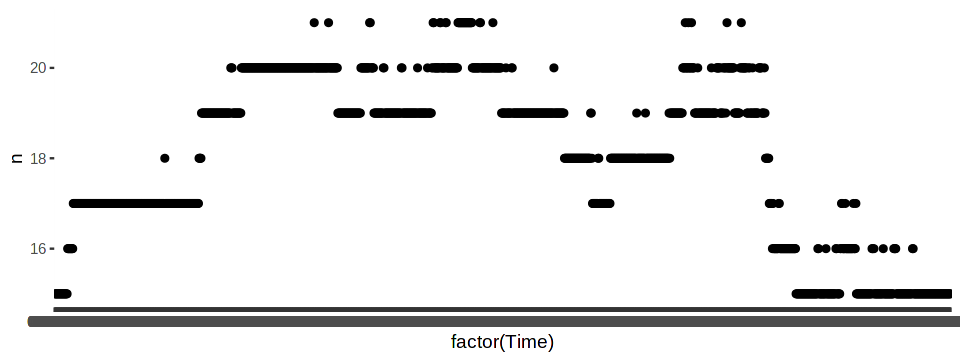

In [16]:
options(repr.plot.width = 8, repr.plot.height = 3)
ggplot(data=power.na %>% group_by(Time) %>% summarise(n=n())) +
    geom_point(aes(x=factor(Time), y=n))

We got that we can count between 15 to 21 missings at different hours. The missing counts are most likely to occure during the day and less during the night. It may be due to measure failures or mantainance of the sensors. As the minimal and maximal counts for the times are not so broad, we can assume that their are missing at random (MAR). As at this time we don't have enough insides about how missing values may affect our analysis. Let's proceed with generating more data based on the existing data (data ) and decide later how will we proceed with the missing values.
 
Lets extract new features from the existing data. We will take the date and time and will generate from them new data:
For the date,  we will separate the country, month and day. We will add also the weekday and the season.

In [ ]:
# since the data has a lot of NA which are not at random, we canot do imputation so we will change the data into a regular data and not time series

In [6]:
if (!require(lubridate)){install.packages("lubridate");require(lubridate)}


Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:base’:

    date




In [7]:
## Datetime
power$datetime <- as.POSIXct(paste(as.IDate(power$Date,'%d/%m/%Y'), power$Time), format="%Y-%m-%d %H:%M:%S")
## date
power$year <- year(as.IDate(power$Date,'%d/%m/%Y'))
power$month <- month(as.IDate(power$Date,'%d/%m/%Y'))
power$day <- day(as.IDate(power$Date,'%d/%m/%Y'))
power$wday <- wday(as.IDate(power$Date,'%d/%m/%Y'))
## time
power$hour <- hour(power$datetime)
power$minute <- minute(power$datetime)
#power$datetime <- NULL

head(power)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,year,month,day,wday,hour,minute
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,2006,12,16,7,17,24
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,2006,12,16,7,17,25
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,2006,12,16,7,17,26
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,2006,12,16,7,17,27
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,2006,12,16,7,17,28
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,2006,12,16,7,17,29


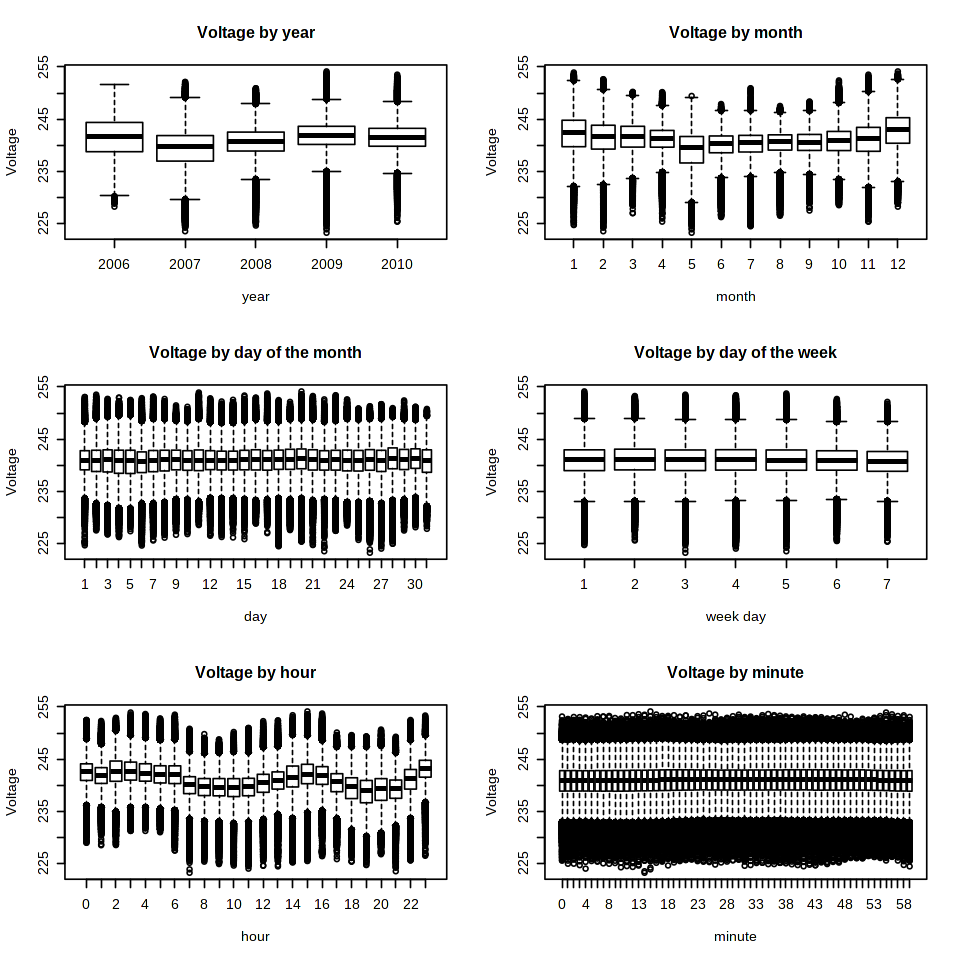

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(3,2))
plot(power$Voltage ~ factor(power$year),main="Voltage by year", xlab="year",ylab="Voltage")
plot(power$Voltage ~ factor(power$mont),main="Voltage by month", xlab="month",ylab="Voltage")
plot(power$Voltage ~ factor(power$day) ,main="Voltage by day of the month", xlab="day",ylab="Voltage")
plot(power$Voltage ~ factor(power$wday),main="Voltage by day of the week", xlab="week day",ylab="Voltage")
plot(power$Voltage ~ factor(power$hour),main="Voltage by hour", xlab="hour",ylab="Voltage")
plot(power$Voltage ~ factor(power$minute),main="Voltage by minute", xlab="minute",ylab="Voltage")
par(mfrow=c(1,1))


In [9]:
if (!require(xts)){install.packages("xts");require(xts)}

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 


Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last


The following objects are masked from ‘package:data.table’:

    first, last




In [10]:
# "xts" transform the data to time-series...but can deel with the NA
power.ts <- xts(power$Voltage,order.by = power$datetime)# power$datetime it take the date and tern into index 
head(power.ts)

                      [,1]
2006-12-16 17:24:00 234.84
2006-12-16 17:25:00 233.63
2006-12-16 17:26:00 233.29
2006-12-16 17:27:00 233.74
2006-12-16 17:28:00 235.68
2006-12-16 17:29:00 235.02

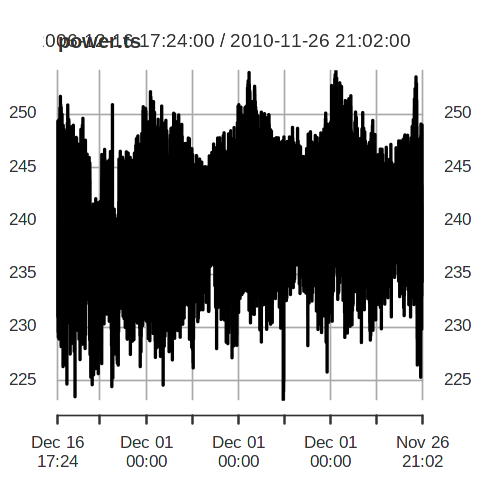

In [11]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(power.ts)

Lets also analyze the missingness as a time series

                    [,1]
2006-12-16 17:24:00    0
2006-12-16 17:25:00    0
2006-12-16 17:26:00    0
2006-12-16 17:27:00    0
2006-12-16 17:28:00    0
2006-12-16 17:29:00    0

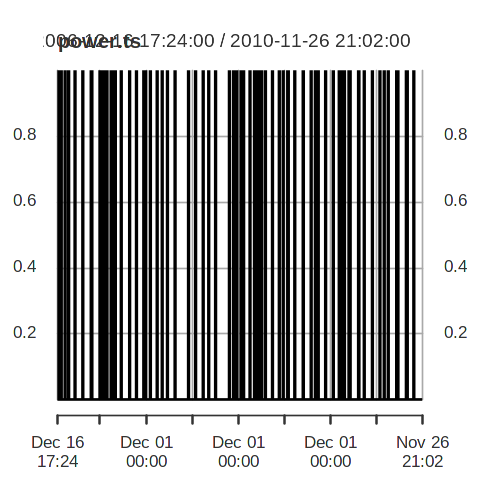

In [25]:
#here we are looking for the NA
power.ts <- xts(ifelse(is.na(power$Voltage)==T,1,0),order.by = power$datetime)
head(power.ts)
plot(power.ts)

In [26]:
power.im <- na.locf(power.ts,fromLast=TRUE)

In [28]:
power.decompose <- decompose(ts(power.im,frequency=3600))

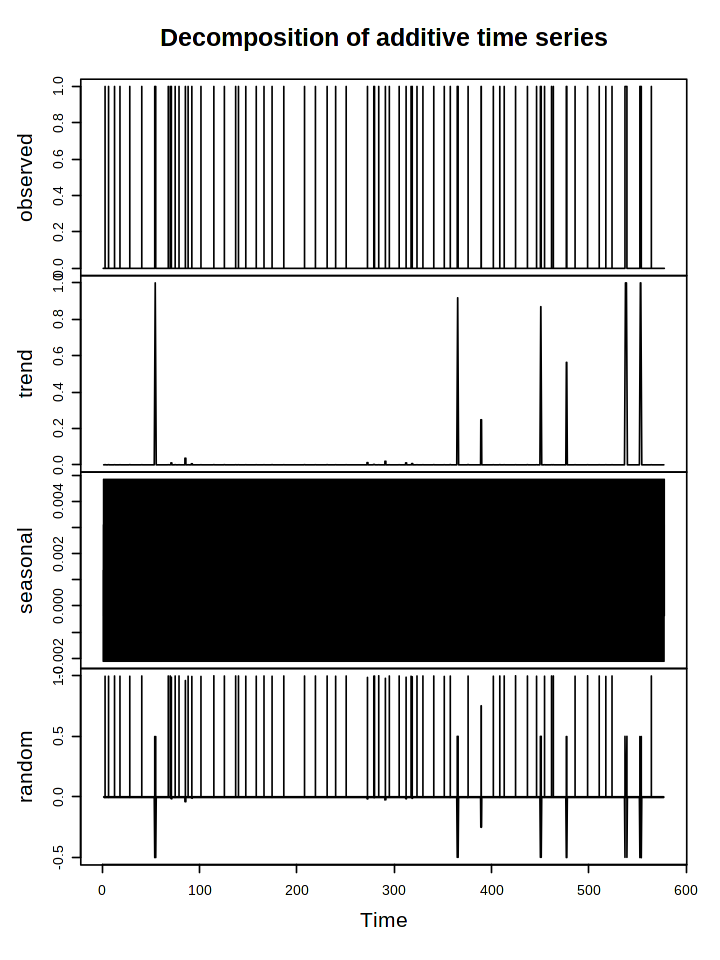

In [30]:
options(repr.plot.width = 6, repr.plot.height = 8)
plot(power.decompose)

In [ ]:
length(power.im)
power.dec1 <- decompose(ts(power.im[1:1000],frequency=60))
plot(power.dec1)

We can see that there is some seasonality on the energy consumption, but we can't say the same for the missingness. As we will not analyze this dataset as a time-series problem. we will obviate the missing dates.
 
Now let's try out our first model. We have to check if it's ok to run linear regression on our dataset. If y (voltage) follows a normal distribution we are safe.

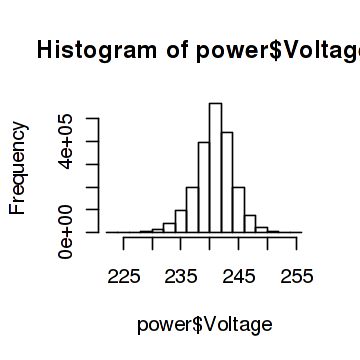

In [16]:
options(repr.plot.width = 3, repr.plot.height = 3)
hist(power$Voltage)

We can assume normality of y, so we can tray to get a model from the available data...

In [17]:
vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3")
#head(power[,..vn])
mod <- lm(Voltage ~., data=power[,..vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power[, ..vn])

Residuals:
    Min      1Q  Median      3Q     Max 
-16.918  -1.586   0.033   1.688  22.470 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)            2.422e+02  3.451e-03 70163.34   <2e-16 ***
Global_active_power    2.127e+01  4.598e-02   462.54   <2e-16 ***
Global_reactive_power  3.625e+00  1.990e-02   182.20   <2e-16 ***
Global_intensity      -5.336e+00  1.091e-02  -488.88   <2e-16 ***
Sub_metering_1         1.045e-02  4.047e-04    25.82   <2e-16 ***
Sub_metering_2         1.767e-02  4.124e-04    42.83   <2e-16 ***
Sub_metering_3        -4.973e-02  3.523e-04  -141.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.809 on 2049273 degrees of freedom
  (25979 observations deleted due to missingness)
Multiple R-squared:  0.2481,	Adjusted R-squared:  0.2481 
F-statistic: 1.127e+05 on 6 and 2049273 DF,  p-value: < 2.2e-16


In [18]:
pred <- predict(mod, newdata=power)

Lets include the date-time derived variables to the model

In [19]:
## hour is not included as it is constant
vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3",
       "year","month","day","wday","hour","minute")
#head(power[,..vn])
mod <- lm(Voltage ~., data=power[,..vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power[, ..vn])

Residuals:
     Min       1Q   Median       3Q      Max 
-17.2247  -1.6071  -0.0164   1.6360  20.6007 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           -1.044e+03  3.446e+00 -302.817  < 2e-16 ***
Global_active_power    1.994e+01  4.453e-02  447.768  < 2e-16 ***
Global_reactive_power  3.026e+00  1.932e-02  156.625  < 2e-16 ***
Global_intensity      -4.957e+00  1.057e-02 -468.944  < 2e-16 ***
Sub_metering_1        -2.023e-03  3.918e-04   -5.163 2.43e-07 ***
Sub_metering_2         7.981e-03  3.990e-04   20.002  < 2e-16 ***
Sub_metering_3        -6.745e-02  3.442e-04 -195.944  < 2e-16 ***
year                   6.404e-01  1.716e-03  373.212  < 2e-16 ***
month                 -4.418e-03  5.554e-04   -7.955 1.79e-15 ***
day                    9.961e-03  2.149e-04   46.356  < 2e-16 ***
wday                  -3.302e-02  9.490e-04  -34.792  < 2e-16 ***
hour                  -3.971e-02  

As we see, all the variables are significant. The R-square was improved from 0.2481 to 0.3029 with our new variables

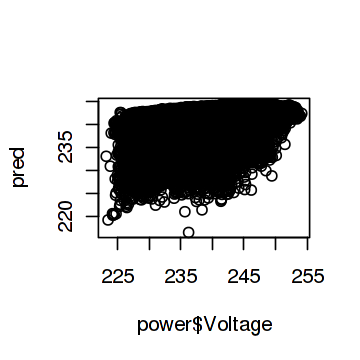

In [21]:
pred <- predict(mod, newdata=power)
plot(pred ~ power$Voltage)

## Searching the internet for additional information that could help us to add important features
 
1. Climate: search google - https://www.google.com/search?q=Sceaux+historical+climate+information&oq=Sceaux+historical+climate+information
 
  1.1 - Seasons in Paris (https://www.parisperfect.com/plan-your-trip/practical-information/weather-in-paris.php)
 
  1.2 - We can find a synoptic table for average climate measures by month (https://en.climate-data.org/europe/france/ile-de-france/sceaux-7899/)
 
  1.3 - World bank climate information portal (http://sdwebx.worldbank.org/climateportal/index.cfm?page=country_historical_climate&ThisCCode=FRA)



#### Seasons in Paris:

 
 - Winter: January - February
 
 - Spring: March - May
 
 - Summer: June - August
 
 - Autumn: September - December
 

In [20]:
power$season <- factor(ifelse(power$month < 3, 1,
                       ifelse(power$month < 6, 2,
                       ifelse(power$month < 9, 3, 4))), levels=c(2,1,3,4), labels=c("Spring","Summer","Autum","Winter"))

head(power)


Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,year,month,day,wday,hour,minute,season
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,2006,12,16,7,17,24,Winter
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,2006,12,16,7,17,25,Winter
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,2006,12,16,7,17,26,Winter
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,2006,12,16,7,17,27,Winter
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,2006,12,16,7,17,28,Winter
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,2006,12,16,7,17,29,Winter


We will check if the added variable (season) improves somehow the model

In [21]:

vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3",
       "year","month","day","wday","hour","minute","season")

mod <- lm(Voltage ~., data=power[,..vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power[, ..vn])

Residuals:
     Min       1Q   Median       3Q      Max 
-17.0898  -1.5518   0.0616   1.6465  18.5694 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           -1.100e+03  3.294e+00 -334.089   <2e-16 ***
Global_active_power    1.648e+01  4.318e-02  381.523   <2e-16 ***
Global_reactive_power  3.869e+00  1.851e-02  208.963   <2e-16 ***
Global_intensity      -4.243e+00  1.021e-02 -415.540   <2e-16 ***
Sub_metering_1         2.297e-02  3.776e-04   60.841   <2e-16 ***
Sub_metering_2         3.008e-02  3.835e-04   78.449   <2e-16 ***
Sub_metering_3        -4.282e-02  3.326e-04 -128.746   <2e-16 ***
year                   6.682e-01  1.640e-03  407.520   <2e-16 ***
month                  1.483e-01  2.057e-03   72.095   <2e-16 ***
day                    1.116e-02  2.048e-04   54.475   <2e-16 ***
wday                  -3.736e-02  9.046e-04  -41.295   <2e-16 ***
hour                  -2.929e-02  

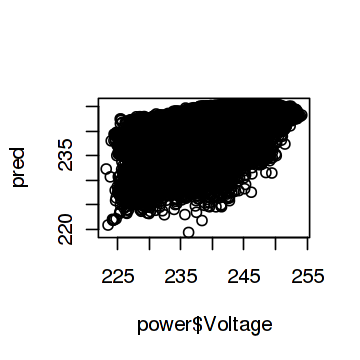

In [24]:
pred <- predict(mod, newdata=power)
plot(pred ~ power$Voltage)

Only by adding a unique variable (season) we improved the R-square from 0.3029 to 0.3668 !

Let's try another one: a feature indicating if there is day or night!

In [22]:
power$night <- factor(ifelse(power$hour < 6 | power$hour > 19, 1, 0),levels=c(0,1),labels=c("Day","Night"))
table(power$night)
head(power)


    Day   Night 
1210596  864663 

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,year,month,day,wday,hour,minute,season,night
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,2006,12,16,7,17,24,Winter,Day
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,2006,12,16,7,17,25,Winter,Day
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,2006,12,16,7,17,26,Winter,Day
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,2006,12,16,7,17,27,Winter,Day
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,2006,12,16,7,17,28,Winter,Day
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,2006,12,16,7,17,29,Winter,Day


In [23]:
vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3",
       "year","month","day","wday","hour","minute","season","night")

mod <- lm(Voltage ~., data=power[,..vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power[, ..vn])

Residuals:
     Min       1Q   Median       3Q      Max 
-16.6982  -1.5390   0.0657   1.6308  18.4055 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           -1.088e+03  3.261e+00 -333.694   <2e-16 ***
Global_active_power    1.564e+01  4.295e-02  364.198   <2e-16 ***
Global_reactive_power  3.860e+00  1.833e-02  210.572   <2e-16 ***
Global_intensity      -4.066e+00  1.015e-02 -400.751   <2e-16 ***
Sub_metering_1         2.694e-02  3.743e-04   71.974   <2e-16 ***
Sub_metering_2         3.775e-02  3.815e-04   98.951   <2e-16 ***
Sub_metering_3        -2.433e-02  3.415e-04  -71.230   <2e-16 ***
year                   6.619e-01  1.623e-03  407.700   <2e-16 ***
month                  1.523e-01  2.036e-03   74.802   <2e-16 ***
day                    1.121e-02  2.028e-04   55.293   <2e-16 ***
wday                  -4.011e-02  8.956e-04  -44.779   <2e-16 ***
hour                  -1.944e-02  

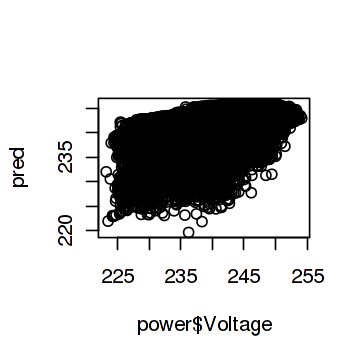

In [28]:
pred <- predict(mod, newdata=power)
plot(pred ~ power$Voltage)

Only by adding a unique variable (season) we improved the R-square from 0.3668 to 0.3794 !
 
This indicates that weather data may have a significant impact on our model. We will import some new data from external sources.

Temperature and rain data

<table id="small_weather_table">
<thead>
<tr>
<th>&nbsp;</th><th>Avg. Temperature (°C)</th><th>Avg. Temperature (°F)</th><th>Precipitation / Rainfall (mm)</th></tr></thead>
<tbody>
<tr><td>January</td><td>3.1</td><td>37.6</td><td>55</td></tr>
<tr><td>February</td><td>4.1</td><td>39.4</td><td>47</td></tr>
<tr><td>March</td><td>7.5</td><td>45.5</td><td>51</td></tr><tr>
<td>April</td><td>10.6</td><td>51.1</td><td>45</td></tr>
<tr><td>May</td><td>13.9</td><td>57.0</td><td>60</td></tr>
<tr><td>June</td><td>17</td><td>62.6</td><td>56</td></tr>
<tr><td>July</td><td>19</td><td>66.2</td><td>54</td></tr>
<tr><td>August</td><td>18.7</td><td>65.7</td><td>52</td></tr>
<tr><td>September</td><td>16</td><td>60.8</td><td>57</td></tr>
<tr><td>October</td><td>11.5</td><td>52.7</td><td>58</td></tr>
<tr><td>November</td><td>7</td><td>44.6</td><td>59</td></tr>
<tr><td>December</td><td>4</td><td>39.2</td><td>55</td></tr>


<table id="weather_table">
<thead>
<tr><th>&nbsp;</th><th>January</th><th>February</th><th>March</th><th>April</th><th>May</th><th>June</th><th>July</th><th>August</th><th>September</th><th>October</th><th>November</th><th>December</th></tr>
</thead>
<tbody>
<tr><td>Avg. Temperature (°C)</td><td>3.1</td><td>4.1</td><td>7.5</td><td>10.6</td><td>13.9</td><td>17</td><td>19</td><td>18.7</td><td>16</td><td>11.5</td><td>7</td><td>4</td></tr>
<tr><td>Min. Temperature (°C)</td><td>0.6</td><td>1.1</td><td>3.2</td><td>5.7</td><td>8.7</td><td>11.8</td><td>13.8</td><td>13.7</td><td>11.3</td><td>7.6</td><td>4.2</td><td>1.6</td></tr>
<tr><td>Max. Temperature (°C)</td><td>5.7</td><td>7.1</td><td>11.8</td><td>15.5</td><td>19.2</td><td>22.3</td><td>24.3</td><td>23.8</td><td>20.8</td><td>15.4</td><td>9.8</td><td>6.4</td></tr>
<tr><td>Avg. Temperature (°F)</td><td>37.6</td><td>39.4</td><td>45.5</td><td>51.1</td><td>57.0</td><td>62.6</td><td>66.2</td><td>65.7</td><td>60.8</td><td>52.7</td><td>44.6</td><td>39.2</td></tr>
<tr><td>Min. Temperature (°F)</td><td>33.1</td><td>34.0</td><td>37.8</td><td>42.3</td><td>47.7</td><td>53.2</td><td>56.8</td><td>56.7</td><td>52.3</td><td>45.7</td><td>39.6</td><td>34.9</td></tr>
<tr><td>Max. Temperature (°F)</td><td>42.3</td><td>44.8</td><td>53.2</td><td>59.9</td><td>66.6</td><td>72.1</td><td> 75.7</td><td>74.8</td><td>69.4</td><td>59.7</td><td>49.6</td><td>43.5</td></tr>
<tr><td>Precipitation / Rainfall (mm)</td><td>55</td><td>47</td><td>51</td><td>45</td><td>60</td><td>56</td><td>54</td><td>52</td><td>57</td><td>58</td><td>59</td><td>55</td></tr>
</tbody>
</table>

### Extract tables from web pages
 
We can import into R tables we found on web pages:


In [24]:
if (!require(XML)){install.packages("XML");require(XML)}
if (!require(RCurl)){install.packages("RCurl");require(RCurl)}
if (!require(rlist)){install.packages("rlist");require(rlist)}


Loading required package: XML
Loading required package: RCurl
Loading required package: bitops
Loading required package: rlist


In [25]:
### read the web page and extract the tables on it
url <- getURL("https://en.climate-data.org/europe/france/ile-de-france/sceaux-7899/",.opts = list(ssl.verifypeer = FALSE) )
tables <- readHTMLTable(url)
str(tables)

List of 2
 $ small_weather_table:'data.frame':	12 obs. of  4 variables:
  ..$                              : Factor w/ 12 levels "April","August",..: 5 4 8 1 9 7 6 2 12 11 ...
  ..$ Avg. Temperature (°C)        : Factor w/ 12 levels "10.6","11.5",..: 8 10 12 1 3 5 7 6 4 2 ...
  ..$ Avg. Temperature (°F)        : Factor w/ 12 levels "37.6","39.2",..: 1 3 5 6 8 10 12 11 9 7 ...
  ..$ Precipitation / Rainfall (mm): Factor w/ 11 levels "45","47","51",..: 6 2 3 1 11 7 5 4 8 9 ...
 $ weather_table      :'data.frame':	7 obs. of  13 variables:
  ..$          : Factor w/ 7 levels "Avg. Temperature (°C)",..: 1 5 3 2 6 4 7
  ..$ January  : Factor w/ 7 levels "0.6","3.1","33.1",..: 2 1 7 4 3 5 6
  ..$ February : Factor w/ 7 levels "1.1","34.0","39.4",..: 4 1 7 3 2 5 6
  ..$ March    : Factor w/ 7 levels "11.8","3.2","37.8",..: 7 2 1 4 3 6 5
  ..$ April    : Factor w/ 7 levels "10.6","15.5",..: 1 6 2 5 3 7 4
  ..$ May      : Factor w/ 7 levels "13.9","19.2",..: 1 7 2 4 3 6 5
  ..$ June     : Factor

In [26]:
tables <- list.clean(tables, fun = is.null, recursive = FALSE)
n.rows <- unlist(lapply(tables, function(t) dim(t)[1]))

In [27]:
n.rows

small_weather_table       weather_table 
                 12                   7

In [28]:
head(tables$small_weather_table)

,Avg. Temperature (°C),Avg. Temperature (°F),Precipitation / Rainfall (mm)
January,3.1,37.6,55
February,4.1,39.4,47
March,7.5,45.5,51
April,10.6,51.1,45
May,13.9,57.0,60
June,17,62.6,56


In [29]:
head(tables$weather_table)

,January,February,March,April,May,June,July,August,September,October,November,December
Avg. Temperature (°C),3.1,4.1,7.5,10.6,13.9,17,19,18.7,16,11.5,7,4
Min. Temperature (°C),0.6,1.1,3.2,5.7,8.7,11.8,13.8,13.7,11.3,7.6,4.2,1.6
Max. Temperature (°C),5.7,7.1,11.8,15.5,19.2,22.3,24.3,23.8,20.8,15.4,9.8,6.4
Avg. Temperature (°F),37.6,39.4,45.5,51.1,57.0,62.6,66.2,65.7,60.8,52.7,44.6,39.2
Min. Temperature (°F),33.1,34.0,37.8,42.3,47.7,53.2,56.8,56.7,52.3,45.7,39.6,34.9
Max. Temperature (°F),42.3,44.8,53.2,59.9,66.6,72.1,75.7,74.8,69.4,59.7,49.6,43.5


In [30]:
## the last table is not in our required format... we transpose it
head(t(tables$weather_table))

,Avg. Temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Avg. Temperature (°F),Min. Temperature (°F),Max. Temperature (°F),Precipitation / Rainfall (mm)
January,3.1,0.6,5.7,37.6,33.1,42.3,55
February,4.1,1.1,7.1,39.4,34.0,44.8,47
March,7.5,3.2,11.8,45.5,37.8,53.2,51
April,10.6,5.7,15.5,51.1,42.3,59.9,45
May,13.9,8.7,19.2,57.0,47.7,66.6,60


As we can appreciate, the content of the first table is included in the second table. So we will use only the second one.
 
We will add the data to our main table. The temperature in °F will be excluded as it will represent the same levels as the °C

In [31]:
weather <- t(tables$weather_table)[2:13,c(1:3,7)]
str(weather)


 chr [1:12, 1:4] "3.1" "4.1" "7.5" "10.6" "13.9" "17" "19" "18.7" "16" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:12] "January" "February" "March" "April" ...
  ..$ : NULL


In [32]:
weather <- type.convert(weather)#,numerals = c("temperature_avg","temperature_min","temperature_max","rain"))
weather <- data.table(weather)
names(weather) <- c("temperature_avg","temperature_min","temperature_max","rain")
weather$month <- c(1:12)
str(weather)
head(weather)

Classes ‘data.table’ and 'data.frame':	12 obs. of  5 variables:
 $ temperature_avg: num  3.1 4.1 7.5 10.6 13.9 17 19 18.7 16 11.5 ...
 $ temperature_min: num  0.6 1.1 3.2 5.7 8.7 11.8 13.8 13.7 11.3 7.6 ...
 $ temperature_max: num  5.7 7.1 11.8 15.5 19.2 22.3 24.3 23.8 20.8 15.4 ...
 $ rain           : num  55 47 51 45 60 56 54 52 57 58 ...
 $ month          : int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, ".internal.selfref")=<externalptr> 


temperature_avg,temperature_min,temperature_max,rain,month
3.1,0.6,5.7,55,1
4.1,1.1,7.1,47,2
7.5,3.2,11.8,51,3
10.6,5.7,15.5,45,4
13.9,8.7,19.2,60,5
17.0,11.8,22.3,56,6


In [33]:

power <- left_join(power, weather, by="month")

In [34]:
head(power)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,⋯,day,wday,hour,minute,season,night,temperature_avg,temperature_min,temperature_max,rain
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,⋯,16,7,17,24,Winter,Day,4,1.6,6.4,55
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,⋯,16,7,17,25,Winter,Day,4,1.6,6.4,55
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,⋯,16,7,17,26,Winter,Day,4,1.6,6.4,55
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,⋯,16,7,17,27,Winter,Day,4,1.6,6.4,55
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,⋯,16,7,17,28,Winter,Day,4,1.6,6.4,55
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,⋯,16,7,17,29,Winter,Day,4,1.6,6.4,55


Now we will create a new model with the added weather variables

In [35]:
vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3",
       "year","month","day","wday","hour","minute","season","night","temperature_avg","temperature_min","temperature_max","rain")
        
mod <- lm(Voltage ~., data=power[,vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power[, vn])

Residuals:
     Min       1Q   Median       3Q      Max 
-15.0846  -1.4576   0.0827   1.5657  16.3849 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.237e+03  3.080e+00 -401.56   <2e-16 ***
Global_active_power    1.279e+01  4.062e-02  314.77   <2e-16 ***
Global_reactive_power  3.974e+00  1.719e-02  231.17   <2e-16 ***
Global_intensity      -3.454e+00  9.582e-03 -360.45   <2e-16 ***
Sub_metering_1         4.185e-02  3.521e-04  118.85   <2e-16 ***
Sub_metering_2         5.180e-02  3.586e-04  144.45   <2e-16 ***
Sub_metering_3        -6.297e-03  3.224e-04  -19.53   <2e-16 ***
year                   7.414e-01  1.533e-03  483.80   <2e-16 ***
month                 -1.096e-01  2.732e-03  -40.11   <2e-16 ***
day                    9.514e-03  1.901e-04   50.05   <2e-16 ***
wday                  -3.469e-02  8.391e-04  -41.35   <2e-16 ***
hour                  -1.244e-02  2.599e-04  -47

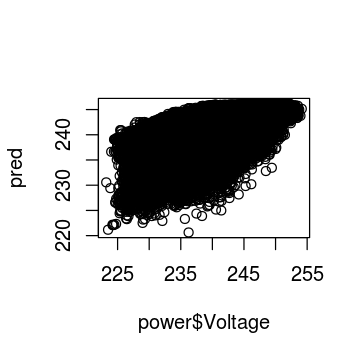

In [60]:
pred <- predict(mod, newdata=power)
plot(pred ~ power$Voltage)

Now, the model is a lot better, and the R-square was improved from 0.3794 to 0.4554 only by adding the average monthly temperature and rain variables !!!
 
The graph also shows a bit better, and we begin to see a trend on it. 

### World bank rain and temperature 
 
We found on our search the world bank temperature and rain data. We yet added such a variable, but it was the monthly average over the years. In the new dataset, we have the measures at a higher resolution (year/month). We will check if adding it will improve our model.
 
The data is presented as excel files. We will read each of them:


In [44]:
#Sys.setenv(JAVA_HOME="")
#if (!require(xlsx)){install.packages("xlsx");require(rlist)}

In [36]:
if (!require(gdata)){install.packages("gdata");require(gdata)}


Loading required package: gdata
gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following objects are masked from ‘package:xts’:

    first, last

The following objects are masked from ‘package:dplyr’:

    combine, first, last

The following objects are masked from ‘package:data.table’:

    first, last

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



In [38]:
wb.temp <- read.xls("/home/tomas/Documents/Technion/Data/tas_1991_2015.xls")
head(wb.temp)

wb.rain <- read.xls("/home/tomas/Documents/Technion/Data/pr_1991_2015.xls")
head(wb.rain)


tas,X.Year,X.Month,X.Country,X.ISO3,X.ISO2
3.79271,1991,1,FRA,NA,NA
3.25842,1991,2,FRA,NA,NA
9.80699,1991,3,FRA,NA,NA
9.28827,1991,4,FRA,NA,NA
11.74500,1991,5,FRA,NA,NA
15.66490,1991,6,FRA,NA,NA


pr,X.Year,X.Month,X.Country,X.ISO3,X.ISO2
55.3925,1991,1,FRA,NA,NA
36.3468,1991,2,FRA,NA,NA
71.2423,1991,3,FRA,NA,NA
49.9777,1991,4,FRA,NA,NA
35.7295,1991,5,FRA,NA,NA
69.0414,1991,6,FRA,NA,NA


In [39]:
dim(wb.temp)
str(wb.temp)
summary(wb.temp)
wb.temp <- wb.temp[,c(2,3,1)]
names(wb.temp) <- c("year", "month", "temperature_month")
summary(wb.temp)

[1] 300   6

'data.frame':	300 obs. of  6 variables:
 $ tas      : num  3.79 3.26 9.81 9.29 11.74 ...
 $ X.Year   : int  1991 1991 1991 1991 1991 1991 1991 1991 1991 1991 ...
 $ X.Month  : int  1 2 3 4 5 6 7 8 9 10 ...
 $ X.Country: Factor w/ 1 level "FRA": 1 1 1 1 1 1 1 1 1 1 ...
 $ X.ISO3   : logi  NA NA NA NA NA NA ...
 $ X.ISO2   : logi  NA NA NA NA NA NA ...


      tas             X.Year        X.Month      X.Country  X.ISO3       
 Min.   : 1.827   Min.   :1991   Min.   : 1.00   FRA:300   Mode:logical  
 1st Qu.: 7.832   1st Qu.:1997   1st Qu.: 3.75             NA's:300      
 Median :11.526   Median :2003   Median : 6.50                           
 Mean   :12.012   Mean   :2003   Mean   : 6.50                           
 3rd Qu.:16.858   3rd Qu.:2009   3rd Qu.: 9.25                           
 Max.   :21.603   Max.   :2015   Max.   :12.00                           
  X.ISO2       
 Mode:logical  
 NA's:300      
               
               
               
               

      year          month       temperature_month
 Min.   :1991   Min.   : 1.00   Min.   : 1.827   
 1st Qu.:1997   1st Qu.: 3.75   1st Qu.: 7.832   
 Median :2003   Median : 6.50   Median :11.526   
 Mean   :2003   Mean   : 6.50   Mean   :12.012   
 3rd Qu.:2009   3rd Qu.: 9.25   3rd Qu.:16.858   
 Max.   :2015   Max.   :12.00   Max.   :21.603   

In [40]:
dim(wb.rain)
summary(wb.rain)
wb.rain <- wb.rain[,c(2,3,1)]
names(wb.rain) <- c("year", "month", "rain_month")
summary(wb.rain)

[1] 300   6

       pr             X.Year        X.Month      X.Country  X.ISO3       
 Min.   : 10.30   Min.   :1991   Min.   : 1.00   FRA:300   Mode:logical  
 1st Qu.: 48.74   1st Qu.:1997   1st Qu.: 3.75             NA's:300      
 Median : 65.71   Median :2003   Median : 6.50                           
 Mean   : 70.08   Mean   :2003   Mean   : 6.50                           
 3rd Qu.: 87.23   3rd Qu.:2009   3rd Qu.: 9.25                           
 Max.   :159.26   Max.   :2015   Max.   :12.00                           
  X.ISO2       
 Mode:logical  
 NA's:300      
               
               
               
               

      year          month         rain_month    
 Min.   :1991   Min.   : 1.00   Min.   : 10.30  
 1st Qu.:1997   1st Qu.: 3.75   1st Qu.: 48.74  
 Median :2003   Median : 6.50   Median : 65.71  
 Mean   :2003   Mean   : 6.50   Mean   : 70.08  
 3rd Qu.:2009   3rd Qu.: 9.25   3rd Qu.: 87.23  
 Max.   :2015   Max.   :12.00   Max.   :159.26  

In [41]:
### joining the monthly temperature
power <- left_join(power,wb.temp,by=c("year","month"),copy=T)
head(power)


Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,⋯,wday,hour,minute,season,night,temperature_avg,temperature_min,temperature_max,rain,temperature_month
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,⋯,7,17,24,Winter,Day,4,1.6,6.4,55,7.57946
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,⋯,7,17,25,Winter,Day,4,1.6,6.4,55,7.57946
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,⋯,7,17,26,Winter,Day,4,1.6,6.4,55,7.57946
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,⋯,7,17,27,Winter,Day,4,1.6,6.4,55,7.57946
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,⋯,7,17,28,Winter,Day,4,1.6,6.4,55,7.57946
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,⋯,7,17,29,Winter,Day,4,1.6,6.4,55,7.57946


In [42]:
### joining the monthly rain (precipitations)
power <- left_join(power,wb.rain,by=c("year","month"),copy=T)
head(power)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,⋯,hour,minute,season,night,temperature_avg,temperature_min,temperature_max,rain,temperature_month,rain_month
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,⋯,17,24,Winter,Day,4,1.6,6.4,55,7.57946,65.5835
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,⋯,17,25,Winter,Day,4,1.6,6.4,55,7.57946,65.5835
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,⋯,17,26,Winter,Day,4,1.6,6.4,55,7.57946,65.5835
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,⋯,17,27,Winter,Day,4,1.6,6.4,55,7.57946,65.5835
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,⋯,17,28,Winter,Day,4,1.6,6.4,55,7.57946,65.5835
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,⋯,17,29,Winter,Day,4,1.6,6.4,55,7.57946,65.5835


Now lets try our new model...

In [43]:
vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3",
       "year","month","day","wday","hour","minute","season","night","temperature_avg","temperature_min","temperature_max","rain","temperature_month","rain_month")

mod <- lm(Voltage ~., data=power[,vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power[, vn])

Residuals:
     Min       1Q   Median       3Q      Max 
-15.3657  -1.4579   0.0738   1.5592  16.5271 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.192e+03  3.209e+00 -371.57   <2e-16 ***
Global_active_power    1.272e+01  4.053e-02  313.85   <2e-16 ***
Global_reactive_power  3.977e+00  1.716e-02  231.75   <2e-16 ***
Global_intensity      -3.439e+00  9.561e-03 -359.65   <2e-16 ***
Sub_metering_1         4.217e-02  3.512e-04  120.07   <2e-16 ***
Sub_metering_2         5.176e-02  3.577e-04  144.71   <2e-16 ***
Sub_metering_3        -6.272e-03  3.215e-04  -19.51   <2e-16 ***
year                   7.189e-01  1.596e-03  450.47   <2e-16 ***
month                 -5.086e-02  2.781e-03  -18.29   <2e-16 ***
day                    9.073e-03  1.896e-04   47.85   <2e-16 ***
wday                  -3.414e-02  8.368e-04  -40.79   <2e-16 ***
hour                  -1.245e-02  2.591e-04  -48

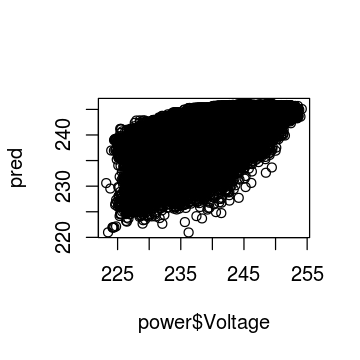

In [37]:
pred <- predict(mod, newdata=power)
plot(pred ~ power$Voltage)

The new variables have added to this model another improvement. The R-square improved from 0.4554 to 0.4584. 
 
We will now try to improve our model a bit more by adding some interaction features

In [44]:
options(repr.plot.width = 3, repr.plot.height = 3)

In [45]:
### more transformations:

power$temperature_delta <- power$temperature_max/power$temperature_min
power$temperature_ratio <- power$temperature_month/power$temperature_avg
power$rain_ratio <- power$rain_month/power$rain

head(power)


Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,⋯,night,temperature_avg,temperature_min,temperature_max,rain,temperature_month,rain_month,temperature_delta,temperature_ratio,rain_ratio
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,⋯,Day,4,1.6,6.4,55,7.57946,65.5835,4,1.894865,1.192427
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,⋯,Day,4,1.6,6.4,55,7.57946,65.5835,4,1.894865,1.192427
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,⋯,Day,4,1.6,6.4,55,7.57946,65.5835,4,1.894865,1.192427
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,⋯,Day,4,1.6,6.4,55,7.57946,65.5835,4,1.894865,1.192427
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,⋯,Day,4,1.6,6.4,55,7.57946,65.5835,4,1.894865,1.192427
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,⋯,Day,4,1.6,6.4,55,7.57946,65.5835,4,1.894865,1.192427


In [46]:
vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3",
       "year","month","day","wday","hour","minute","season","night","temperature_avg","temperature_min","temperature_max","rain","temperature_month","rain_month",
       "temperature_delta","temperature_ratio","rain_ratio")

mod <- lm(Voltage ~., data=power[,vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power[, vn])

Residuals:
     Min       1Q   Median       3Q      Max 
-16.0225  -1.4543   0.0627   1.5385  16.2357 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.267e+03  3.322e+00 -381.30   <2e-16 ***
Global_active_power    1.231e+01  4.016e-02  306.42   <2e-16 ***
Global_reactive_power  3.814e+00  1.700e-02  224.26   <2e-16 ***
Global_intensity      -3.342e+00  9.473e-03 -352.86   <2e-16 ***
Sub_metering_1         4.310e-02  3.477e-04  123.97   <2e-16 ***
Sub_metering_2         5.196e-02  3.539e-04  146.80   <2e-16 ***
Sub_metering_3        -5.300e-03  3.182e-04  -16.66   <2e-16 ***
year                   7.467e-01  1.646e-03  453.50   <2e-16 ***
month                  1.820e-01  3.420e-03   53.20   <2e-16 ***
day                    8.149e-03  1.877e-04   43.41   <2e-16 ***
wday                  -3.596e-02  8.279e-04  -43.43   <2e-16 ***
hour                  -1.183e-02  2.564e-04  -46

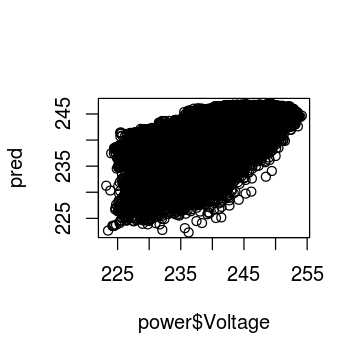

In [82]:
pred <- predict(mod, newdata=power)
plot(pred ~ power$Voltage)

We added another bit of improvement. The R-square improved from 0.4584 to 0.470 !!!

In [58]:
### Add time-series based data
names(power.ts) <- "Votlage"
head(power.ts)

                    Votlage
2006-12-16 17:24:00  234.84
2006-12-16 17:25:00  233.63
2006-12-16 17:26:00  233.29
2006-12-16 17:27:00  233.74
2006-12-16 17:28:00  235.68
2006-12-16 17:29:00  235.02

In [61]:
if (!require(TTR)){install.packages("TTR");require(TTR)}
if (!require(imputeTS)){install.packages("imputeTS");require(imputeTS)}

Loading required package: imputeTS
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘imputeTS’”Installing package into ‘/home/tomas/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependency ‘stinepack’

Loading required package: imputeTS

Attaching package: ‘imputeTS’

The following object is masked from ‘package:zoo’:

    na.locf



In [68]:
## Impute missing values using "Last Observation Carried Forward"
power.ts$Voltage <- na.locf(power.ts$Votlage)

vec <- which(!complete.cases(power.ts))  # rows 2305 2398
power.ts2 <- power.ts[-vec, ]
head(power.ts)

                    Votlage
2006-12-16 17:24:00  234.84
2006-12-16 17:25:00  233.63
2006-12-16 17:26:00  233.29
2006-12-16 17:27:00  233.74
2006-12-16 17:28:00  235.68
2006-12-16 17:29:00  235.02

In [74]:
## add new variables
power.ts$Voltage_last5_min <- runMin(power.ts, n = 5)
head(power.ts,10)

                    Votlage Voltage_last5_min
2006-12-16 17:24:00  234.84                NA
2006-12-16 17:25:00  233.63                NA
2006-12-16 17:26:00  233.29                NA
2006-12-16 17:27:00  233.74                NA
2006-12-16 17:28:00  235.68            233.29
2006-12-16 17:29:00  235.02            233.29
2006-12-16 17:30:00  235.09            233.29
2006-12-16 17:31:00  235.22            233.74
2006-12-16 17:32:00  233.99            233.99
2006-12-16 17:33:00  233.86            233.86

In [77]:
power.ts$Voltage_last5_max <- runMax(power.ts[,1], n = 5)
power.ts$Voltage_last5_sd <- runSD(power.ts[,1], n = 5)
head(power.ts,10)

                    Votlage Voltage_last5_min Voltage_last5_max
2006-12-16 17:24:00  234.84                NA                NA
2006-12-16 17:25:00  233.63                NA                NA
2006-12-16 17:26:00  233.29                NA                NA
2006-12-16 17:27:00  233.74                NA                NA
2006-12-16 17:28:00  235.68            233.29            235.68
2006-12-16 17:29:00  235.02            233.29            235.68
2006-12-16 17:30:00  235.09            233.29            235.68
2006-12-16 17:31:00  235.22            233.74            235.68
2006-12-16 17:32:00  233.99            233.99            235.68
2006-12-16 17:33:00  233.86            233.86            235.22
                    Voltage_last5_sd
2006-12-16 17:24:00               NA
2006-12-16 17:25:00               NA
2006-12-16 17:26:00               NA
2006-12-16 17:27:00               NA
2006-12-16 17:28:00        0.9947512
2006-12-16 17:29:00        1.0248756
2006-12-16 17:30:00        1.0040070


In [81]:
power_ts2 <- data.frame(power.ts)
power_ts2$datetime <- index(power.ts)

Warning message in data.row.names(row.names, rowsi, i):
“some row.names duplicated: 148778,148780,148782,148784,148786,148788,148790,148792,148794,148796,148798,148800,148802,148804,148806,148808,148810,148812,148814,148816,148818,148820,148822,148824,148826,148828,148830,148832,148834,148836,148838,148840,148842,148844,148846,148848,148850,148852,148854,148856,148858,148860,148862,148864,148866,148868,148870,148872,148874,148876,148878,148880,148882,148884,148886,148888,148890,148892,148894,148896,672938,672940,672942,672944,672946,672948,672950,672952,672954,672956,672958,672960,672962,672964,672966,672968,672970,672972,672974,672976,672978,672980,672982,672984,672986,672988,672990,672992,672994,672996,672998,673000,673002,673004,673006,673008,673010,673012,673014,673016,673018,673020,673022,673024,673026,673028,673030,673032,673034,673036,673038,673040,673042,673044,673046,673048,673050,673052,673054,673056,1197098,1197100,1197102,1197104,1197106,1197108,1197110,1197112,1197114,1197

In [82]:
head(power_ts2)

Votlage,Voltage_last5_min,Voltage_last5_max,Voltage_last5_sd,datetime
234.84,NA,NA,NA,2006-12-16 17:24:00
233.63,NA,NA,NA,2006-12-16 17:25:00
233.29,NA,NA,NA,2006-12-16 17:26:00
233.74,NA,NA,NA,2006-12-16 17:27:00
235.68,233.29,235.68,0.9947512,2006-12-16 17:28:00
235.02,233.29,235.68,1.0248756,2006-12-16 17:29:00


In [83]:
str(power_ts2)

'data.frame':	2075259 obs. of  5 variables:
 $ Votlage          : num  235 234 233 234 236 ...
 $ Voltage_last5_min: num  NA NA NA NA 233 ...
 $ Voltage_last5_max: num  NA NA NA NA 236 ...
 $ Voltage_last5_sd : num  NA NA NA NA 0.995 ...
 $ datetime         : POSIXct, format: "2006-12-16 17:24:00" "2006-12-16 17:25:00" ...


In [87]:
power2 <- left_join(power, power_ts2)


Joining, by = "datetime"


In [89]:
head(power2)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,⋯,temperature_max,rain,temperature_month,rain_month,temperature_delta,temperature_ratio,rain_ratio,Voltage_last5_min,Voltage_last5_max,Voltage_last5_sd
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,⋯,6.4,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,⋯,6.4,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,⋯,6.4,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,⋯,6.4,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,⋯,6.4,55,7.57946,65.5835,4,1.894865,1.192427,233.29,235.68,0.9947512
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,⋯,6.4,55,7.57946,65.5835,4,1.894865,1.192427,233.29,235.68,1.0248756


In [91]:
vn <- c("Voltage","Global_active_power","Global_reactive_power","Global_intensity","Sub_metering_1",
        "Sub_metering_2","Sub_metering_3","year","month","day","wday","hour","minute","season","night",
        "temperature_avg","temperature_min","temperature_max","rain","temperature_month","rain_month",
        "temperature_delta","temperature_ratio","rain_ratio","Voltage_last5_min","Voltage_last5_max",
        "Voltage_last5_sd")

mod <- lm(Voltage ~., data=power2[,vn])
summary(mod)


Call:
lm(formula = Voltage ~ ., data = power2[, vn])

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0447 -0.3699  0.0066  0.3708  5.9835 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           -1.735e+01  8.678e-01  -19.995  < 2e-16 ***
Global_active_power    9.870e-01  1.036e-02   95.256  < 2e-16 ***
Global_reactive_power  2.444e-01  4.336e-03   56.362  < 2e-16 ***
Global_intensity      -2.700e-01  2.463e-03 -109.611  < 2e-16 ***
Sub_metering_1        -2.278e-03  8.804e-05  -25.877  < 2e-16 ***
Sub_metering_2         3.412e-03  8.969e-05   38.046  < 2e-16 ***
Sub_metering_3         4.546e-03  8.040e-05   56.547  < 2e-16 ***
year                   1.177e-02  4.360e-04   26.991  < 2e-16 ***
month                  3.325e-03  8.630e-04    3.852 0.000117 ***
day                    1.136e-04  4.735e-05    2.399 0.016420 *  
wday                  -1.934e-03  2.088e-04   -9.262  < 2e-16 ***
hour                   4.537e-03  6.474e-05  

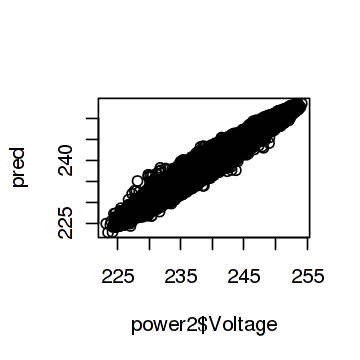

In [92]:
pred <- predict(mod, newdata=power2)
plot(pred ~ power2$Voltage)

Adding the last 5 time periods data increased up the R-square to 0.9663 !!!!
 
Now, in such a case, the R-square becomes a not so useful metrics, as it shows the high correlation existing between the last 5 measures and the current measure!!!
 
We will add now a new variable, and it will become the new outcome variable: the delta-Voltage. We will indicate with it the increase/decrease of the voltage relative to the last measure...

In [108]:
power.ts <- xts(power$Voltage,order.by = power$datetime)
head(power.ts)

                      [,1]
2006-12-16 17:24:00 234.84
2006-12-16 17:25:00 233.63
2006-12-16 17:26:00 233.29
2006-12-16 17:27:00 233.74
2006-12-16 17:28:00 235.68
2006-12-16 17:29:00 235.02

In [98]:
#vec <- which(!complete.cases(power.ts))  
#power.ts <- power.ts[-vec, ]


In [109]:
names(power.ts) <- "Voltage"
power.ts$last_measure <- lag(power.ts[,1],n = 1)
head(power.ts)

                    Voltage last_measure
2006-12-16 17:24:00  234.84           NA
2006-12-16 17:25:00  233.63       234.84
2006-12-16 17:26:00  233.29       233.63
2006-12-16 17:27:00  233.74       233.29
2006-12-16 17:28:00  235.68       233.74
2006-12-16 17:29:00  235.02       235.68

In [110]:
power.ts$delta_Voltage <- power.ts$last_measure - power.ts$Voltage
head(power.ts)

                    Voltage last_measure delta_Voltage
2006-12-16 17:24:00  234.84           NA            NA
2006-12-16 17:25:00  233.63       234.84          1.21
2006-12-16 17:26:00  233.29       233.63          0.34
2006-12-16 17:27:00  233.74       233.29         -0.45
2006-12-16 17:28:00  235.68       233.74         -1.94
2006-12-16 17:29:00  235.02       235.68          0.66

In [112]:
power_ts2 <- data.frame(power.ts)
power_ts2$datetime <- index(power.ts)
head(power_ts2)

Warning message in data.row.names(row.names, rowsi, i):
“some row.names duplicated: 148778,148780,148782,148784,148786,148788,148790,148792,148794,148796,148798,148800,148802,148804,148806,148808,148810,148812,148814,148816,148818,148820,148822,148824,148826,148828,148830,148832,148834,148836,148838,148840,148842,148844,148846,148848,148850,148852,148854,148856,148858,148860,148862,148864,148866,148868,148870,148872,148874,148876,148878,148880,148882,148884,148886,148888,148890,148892,148894,148896,672938,672940,672942,672944,672946,672948,672950,672952,672954,672956,672958,672960,672962,672964,672966,672968,672970,672972,672974,672976,672978,672980,672982,672984,672986,672988,672990,672992,672994,672996,672998,673000,673002,673004,673006,673008,673010,673012,673014,673016,673018,673020,673022,673024,673026,673028,673030,673032,673034,673036,673038,673040,673042,673044,673046,673048,673050,673052,673054,673056,1197098,1197100,1197102,1197104,1197106,1197108,1197110,1197112,1197114,1197

Voltage,last_measure,delta_Voltage,datetime
234.84,NA,NA,2006-12-16 17:24:00
233.63,234.84,1.21,2006-12-16 17:25:00
233.29,233.63,0.34,2006-12-16 17:26:00
233.74,233.29,-0.45,2006-12-16 17:27:00
235.68,233.74,-1.94,2006-12-16 17:28:00
235.02,235.68,0.66,2006-12-16 17:29:00


In [114]:
power2 <- left_join(power2, power_ts2[,c("datetime","delta_Voltage")])

Joining, by = "datetime"


In [115]:
head(power2)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,⋯,rain,temperature_month,rain_month,temperature_delta,temperature_ratio,rain_ratio,Voltage_last5_min,Voltage_last5_max,Voltage_last5_sd,delta_Voltage
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,2006-12-16 17:24:00,⋯,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA,NA
16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0,1,16,2006-12-16 17:25:00,⋯,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA,1.21
16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0,2,17,2006-12-16 17:26:00,⋯,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA,0.34
16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0,1,17,2006-12-16 17:27:00,⋯,55,7.57946,65.5835,4,1.894865,1.192427,NA,NA,NA,-0.45
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,2006-12-16 17:28:00,⋯,55,7.57946,65.5835,4,1.894865,1.192427,233.29,235.68,0.9947512,-1.94
16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0,2,17,2006-12-16 17:29:00,⋯,55,7.57946,65.5835,4,1.894865,1.192427,233.29,235.68,1.0248756,0.66


In [116]:
write.csv(power2,file="power_consumption_enriched2.csv")